In [5]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install ipywidgets

Note: you may need to restart the kernel to use updated packages.


In [33]:
import numpy as np
import pandas as pd
import lightgbm
from lightgbm import LGBMRegressor
import catboost
from catboost import CatBoostRegressor
import sklearn
from sklearn.model_selection import KFold
import IPython
from IPython.display import clear_output
import copy
import matplotlib.pyplot as plt

In [4]:
# import datasets
train = pd.read_csv('../dataset/train.csv')
test = pd.read_csv('../dataset/test.csv')
building = pd.read_csv('../dataset/building_info.csv')
submission = pd.read_csv('../dataset/sample_submission.csv')

In [7]:
display(train)
display(test)

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
0,1_20220601 00,1,20220601 00,18.6,NaN,0.9,42.0,NaN,NaN,1085.28
1,1_20220601 01,1,20220601 01,18.0,NaN,1.1,45.0,NaN,NaN,1047.36
2,1_20220601 02,1,20220601 02,17.7,NaN,1.5,45.0,NaN,NaN,974.88
3,1_20220601 03,1,20220601 03,16.7,NaN,1.4,48.0,NaN,NaN,953.76
4,1_20220601 04,1,20220601 04,18.4,NaN,2.8,43.0,NaN,NaN,986.40
...,...,...,...,...,...,...,...,...,...,...
203995,100_20220824 19,100,20220824 19,23.1,NaN,0.9,86.0,0.5,NaN,881.04
203996,100_20220824 20,100,20220824 20,22.4,NaN,1.3,86.0,0.0,NaN,798.96
203997,100_20220824 21,100,20220824 21,21.3,NaN,1.0,92.0,NaN,NaN,825.12
203998,100_20220824 22,100,20220824 22,21.0,NaN,0.3,94.0,NaN,NaN,640.08


,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%)
0,1_20220825 00,1,20220825 00,23.5,0.0,2.2,72
1,1_20220825 01,1,20220825 01,23.0,0.0,0.9,72
2,1_20220825 02,1,20220825 02,22.7,0.0,1.5,75
3,1_20220825 03,1,20220825 03,22.1,0.0,1.3,78
4,1_20220825 04,1,20220825 04,21.8,0.0,1.0,77
...,...,...,...,...,...,...,...
16795,100_20220831 19,100,20220831 19,22.5,0.0,0.9,84
16796,100_20220831 20,100,20220831 20,20.7,0.0,0.4,95
16797,100_20220831 21,100,20220831 21,20.2,0.0,0.4,98
16798,100_20220831 22,100,20220831 22,20.1,0.0,1.1,97


In [75]:
train_df = train.copy()

train_df = train_df.drop(columns =  ['num_date_time', '일조(hr)', '일사(MJ/m2)'])
train_df = train_df.rename(columns = {'기온(C)':'기온', '강수량(mm)':'강수량', '풍속(m/s)':'풍속', '습도(%)':'습도', '전력소비량(kWh)':'전력소비량'})
train_df['일시'] = pd.to_datetime(train_df['일시'])
train_df['시간'] = train_df['일시'].dt.hour
train_df['요일'] = train_df['일시'].dt.weekday
train_df['주말'] = train_df['요일'].isin([5,6]).astype(int)
train_df = train_df.fillna(0)
train_df = train_df.drop(columns = '일시')

In [76]:
T = 9/5*train_df['기온']
train_df['불쾌지수'] = T - 0.55*(1-train_df['습도']/100)*(T-26)+32
train_df['불쾌지수'] = pd.cut(train_df['불쾌지수'], bins = [0, 68, 75, 80, 200], labels = [1, 2, 3, 4])

(array([22498.,     0.,     0., 59862.,     0.,     0., 80715.,     0.,
            0., 40925.]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <BarContainer object of 10 artists>)

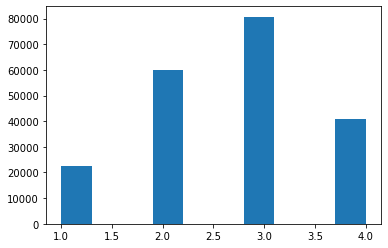

In [77]:
plt.hist(train_df['불쾌지수'])

In [78]:
train_df

,건물번호,기온,강수량,풍속,습도,전력소비량,시간,요일,주말,불쾌지수
0,1,18.6,0.0,0.9,42.0,1085.28,0,2,0,1
1,1,18.0,0.0,1.1,45.0,1047.36,1,2,0,1
2,1,17.7,0.0,1.5,45.0,974.88,2,2,0,1
3,1,16.7,0.0,1.4,48.0,953.76,3,2,0,1
4,1,18.4,0.0,2.8,43.0,986.40,4,2,0,1
...,...,...,...,...,...,...,...,...,...,...
203995,100,23.1,0.0,0.9,86.0,881.04,19,2,0,2
203996,100,22.4,0.0,1.3,86.0,798.96,20,2,0,2
203997,100,21.3,0.0,1.0,92.0,825.12,21,2,0,2
203998,100,21.0,0.0,0.3,94.0,640.08,22,2,0,2


In [79]:
def CDH(x):
    y = []
    for i in range(len(x)):
        if i<11:
            y.append(np.sum(x[:(i+1)]-26))
        else:
            y.append(np.sum(x[(i-11):(i+1)]-26))
    return np.array(x)

In [80]:
cdhs = np.array([])

for num in range(1, 101):
    temp = train_df[train_df['건물번호'] == num]
    cdh = CDH(temp['기온'].values)
    cdhs = np.concatenate([cdhs, cdh])

train_df['CDH'] = cdhs

In [81]:
train_df

,건물번호,기온,강수량,풍속,습도,전력소비량,시간,요일,주말,불쾌지수,CDH
0,1,18.6,0.0,0.9,42.0,1085.28,0,2,0,1,18.6
1,1,18.0,0.0,1.1,45.0,1047.36,1,2,0,1,18.0
2,1,17.7,0.0,1.5,45.0,974.88,2,2,0,1,17.7
3,1,16.7,0.0,1.4,48.0,953.76,3,2,0,1,16.7
4,1,18.4,0.0,2.8,43.0,986.40,4,2,0,1,18.4
...,...,...,...,...,...,...,...,...,...,...,...
203995,100,23.1,0.0,0.9,86.0,881.04,19,2,0,2,23.1
203996,100,22.4,0.0,1.3,86.0,798.96,20,2,0,2,22.4
203997,100,21.3,0.0,1.0,92.0,825.12,21,2,0,2,21.3
203998,100,21.0,0.0,0.3,94.0,640.08,22,2,0,2,21.0


In [106]:
train_ = train_df.copy()
train_input = train_.drop(columns = '전력소비량')
train_target = train_df['전력소비량']

In [108]:
train_df = train.copy()

train_df = train_df.drop(columns =  ['num_date_time', '일조(hr)', '일사(MJ/m2)'])
train_df = train_df.rename(columns = {'기온(C)':'기온', '강수량(mm)':'강수량', '풍속(m/s)':'풍속', '습도(%)':'습도', '전력소비량(kWh)':'전력소비량'})
train_df['일시'] = pd.to_datetime(train_df['일시'])
train_df['시간'] = train_df['일시'].dt.hour
train_df['요일'] = train_df['일시'].dt.weekday
train_df['주말'] = train_df['요일'].isin([5,6]).astype(int)
train_df = train_df.fillna(0)
train_df = train_df.drop(columns = '일시')

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%)
0,1_20220825 00,1,20220825 00,23.5,0.0,2.2,72
1,1_20220825 01,1,20220825 01,23.0,0.0,0.9,72
2,1_20220825 02,1,20220825 02,22.7,0.0,1.5,75
3,1_20220825 03,1,20220825 03,22.1,0.0,1.3,78
4,1_20220825 04,1,20220825 04,21.8,0.0,1.0,77
...,...,...,...,...,...,...,...
16795,100_20220831 19,100,20220831 19,22.5,0.0,0.9,84
16796,100_20220831 20,100,20220831 20,20.7,0.0,0.4,95
16797,100_20220831 21,100,20220831 21,20.2,0.0,0.4,98
16798,100_20220831 22,100,20220831 22,20.1,0.0,1.1,97


In [100]:
random_seed = 0
features = [[], '강수량', '풍속', '불쾌지수', 'CDH']
K = [i for i in range(2, 11)]

cat_mae_params = {
    'objective': 'MAE',
    'n_estimators': 10000,
    'early_stopping_rounds': 4, 
} #catboost hyper parameter

lgbm_mae_params = {
    'objective': 'MAE',
    'boosting_type': 'goss',
    'n_estimators': 10000,
    'early_stopping_round': 15, 
    'num_leaves':39,
} #lightgbm hyper parameter

for feature in features: # 특정 feature dc를 drop 시킴
    for k in K: # kfold 의 nspilt 의 값 k
        folds = []
        for i in range(len(train_df)):
            cross = KFold(n_splits = k, shuffle = True, random_state = random_seed)
            fold = []
            for train_idx, valid_idx in cross.split(train_input[i], train_target[i]):
                fold.append((train_idx, valid_idx))
            folds.append(fold)
            
        for i in range(len(train_df)):
            for fold in range(k):
                print(feature, random_seed, k, i)
                train_idx, valid_idx = folds[i][fold]
                X_train=np.array(train_input[i].drop(columns = feature).iloc[train_idx])
                y_train=np.array(train_target[i].iloc[train_idx])
                X_valid=np.array(train_input[i].drop(columns = feature).iloc[valid_idx])
                y_valid=np.array(train_target[i].iloc[valid_idx])
                
                # catboost 학습 
                model = CatBoostRegressor(**cat_mae_params)
                model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=100)
                v = model.predict(np.array(test_dfs[i][train_x[i].drop(columns=dc).columns])) * 0.3
                
                #lgbm 학습 
                model=LGBMRegressor(**lgbm_mae_params)
                model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=100)        
                v += model.predict(np.array(test_dfs[i][train_x[i].drop(columns=dc).columns])) * 0.7
                
                submission['answer'].iloc[(i)*168:(i+1)*168] += v/(len(ks)*k*len(dcs))
                clear_output(True) 
                
        random_seed += 1

submission.to_csv('../submission/answer1.csv', index = False) #파일 저장

,건물번호,기온,강수량,풍속,습도,전력소비량,시간,요일,주말,불쾌지수,CDH
0,1,18.6,0.0,0.9,42.0,1085.28,0,2,0,1,18.6
1,1,18.0,0.0,1.1,45.0,1047.36,1,2,0,1,18.0
2,1,17.7,0.0,1.5,45.0,974.88,2,2,0,1,17.7
3,1,16.7,0.0,1.4,48.0,953.76,3,2,0,1,16.7
4,1,18.4,0.0,2.8,43.0,986.40,4,2,0,1,18.4
...,...,...,...,...,...,...,...,...,...,...,...
203995,100,23.1,0.0,0.9,86.0,881.04,19,2,0,2,23.1
203996,100,22.4,0.0,1.3,86.0,798.96,20,2,0,2,22.4
203997,100,21.3,0.0,1.0,92.0,825.12,21,2,0,2,21.3
203998,100,21.0,0.0,0.3,94.0,640.08,22,2,0,2,21.0


In [107]:
submission

,num_date_time,answer
0,1_20220825 00,0
1,1_20220825 01,0
2,1_20220825 02,0
3,1_20220825 03,0
4,1_20220825 04,0
...,...,...
16795,100_20220831 19,0
16796,100_20220831 20,0
16797,100_20220831 21,0
16798,100_20220831 22,0


In [ ]:
t

,건물번호,기온,강수량,풍속,습도,전력소비량,시간,요일,주말,불쾌지수,CDH
0,1,18.6,0.0,0.9,42.0,1085.28,0,2,0,1,18.6
1,1,18.0,0.0,1.1,45.0,1047.36,1,2,0,1,18.0
2,1,17.7,0.0,1.5,45.0,974.88,2,2,0,1,17.7
3,1,16.7,0.0,1.4,48.0,953.76,3,2,0,1,16.7
4,1,18.4,0.0,2.8,43.0,986.40,4,2,0,1,18.4
...,...,...,...,...,...,...,...,...,...,...,...
203995,100,23.1,0.0,0.9,86.0,881.04,19,2,0,2,23.1
203996,100,22.4,0.0,1.3,86.0,798.96,20,2,0,2,22.4
203997,100,21.3,0.0,1.0,92.0,825.12,21,2,0,2,21.3
203998,100,21.0,0.0,0.3,94.0,640.08,22,2,0,2,21.0


In [83]:
#이상치 제거 iqr은 1.25
for i in range(100):    
    idx = detect_outliers(train_y[i],1.25)
    train_y[i] = train_y[i][idx]
    train_x[i] = train_x[i][idx]

In [88]:
train_dfs

[      건물번호    기온  강수량   풍속    습도    전력소비량  시간  요일  주말 불쾌지수   CDH
 0        1  18.6  0.0  0.9  42.0  1085.28   0   2   0    1  18.6
 1        1  18.0  0.0  1.1  45.0  1047.36   1   2   0    1  18.0
 2        1  17.7  0.0  1.5  45.0   974.88   2   2   0    1  17.7
 3        1  16.7  0.0  1.4  48.0   953.76   3   2   0    1  16.7
 4        1  18.4  0.0  2.8  43.0   986.40   4   2   0    1  18.4
 ...    ...   ...  ...  ...   ...      ...  ..  ..  ..  ...   ...
 2035     1  25.5  0.0  2.9  63.0  2517.12  19   2   0    2  25.5
 2036     1  25.0  0.0  2.6  66.0  2208.96  20   2   0    2  25.0
 2037     1  24.6  0.0  1.3  67.0  1806.24  21   2   0    2  24.6
 2038     1  24.1  0.0  2.1  70.0  1387.20  22   2   0    2  24.1
 2039     1  23.8  0.0  1.4  70.0  1925.28  23   2   0    2  23.8
 
 [2040 rows x 11 columns],
       건물번호    기온  강수량   풍속    습도    전력소비량  시간  요일  주말 불쾌지수   CDH
 2040     2  18.6  0.0  0.9  42.0  1170.36   0   2   0    1  18.6
 2041     2  18.0  0.0  1.1  45.0  1146.96   1 

In [85]:
random_seed = 0
K = [i for i in range(2, 11)]



In [86]:
test

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%)
0,1_20220825 00,1,20220825 00,23.5,0.0,2.2,72
1,1_20220825 01,1,20220825 01,23.0,0.0,0.9,72
2,1_20220825 02,1,20220825 02,22.7,0.0,1.5,75
3,1_20220825 03,1,20220825 03,22.1,0.0,1.3,78
4,1_20220825 04,1,20220825 04,21.8,0.0,1.0,77
...,...,...,...,...,...,...,...
16795,100_20220831 19,100,20220831 19,22.5,0.0,0.9,84
16796,100_20220831 20,100,20220831 20,20.7,0.0,0.4,95
16797,100_20220831 21,100,20220831 21,20.2,0.0,0.4,98
16798,100_20220831 22,100,20220831 22,20.1,0.0,1.1,97
